In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from zNet import one_hot, decode_label
from torch.utils.data import Dataset, DataLoader

In [3]:
data = (pd.read_csv("data/train.csv")).values
# Shuffle the data
np.random.shuffle(data)

# Split the test/train dataset
m, n = data.shape
test_ratio = 0.25

m_test = int(m * 0.25)
X_test = data[:m_test, 1:] / 255
y_test = data[:m_test, 0]

X_train = data[m_test:, 1:] / 255
y_train = data[m_test:, 0]

In [19]:
X_train.shape

(31500, 784)

In [14]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


In [28]:
batch_size = 64
# Instantiate training and test data
train_data = Data(X_train, one_hot(y_train))
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, one_hot(y_test))
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


Batch: 0
X shape: torch.Size([64, 784])
y shape: torch.Size([64, 10])


### 0. Load Tensor

In [29]:
X = torch.tensor(X_train, dtype=torch.float)
y = torch.tensor(one_hot(y_train), dtype=torch.int)

In [30]:
X.shape, y.shape

(torch.Size([31500, 784]), torch.Size([31500, 10]))

### 1. Set up the Neural Net

In [31]:
input_dim = X.shape[1]
hidden_dim = 16
output_dim = 10


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(in_features=input_dim, out_features=hidden_dim)
        self.hidden_1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.output = nn.Linear(in_features=hidden_dim, out_features=output_dim)

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.softmax(self.hidden_1(x), dim=1)
        return self.output(x)


In [32]:
model = Net(input_dim, hidden_dim, output_dim)

In [33]:
print(model)

Net(
  (input): Linear(in_features=784, out_features=16, bias=True)
  (hidden_1): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=10, bias=True)
)


In [34]:
learning_rate = 0.1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training

In [36]:
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

"""
Training Complete
"""

Training Complete


'\nTraining Complete\n'

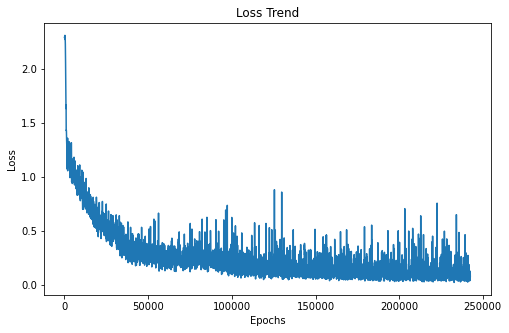

In [45]:
## Visualize the loss track
fig, ax = plt.subplots(figsize=(8,5))
idx_arr = np.arange(0, len(loss_values), batch_size)


plt.plot(idx_arr, np.array(loss_values)[idx_arr])
plt.title("Loss Trend")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Test Set

In [51]:
pred_test = model(torch.from_numpy(X_test.astype(np.float32)))

In [52]:
pred_test

tensor([[ -7.7864,  -1.3727, -12.0691,  ...,   9.8173,  -0.4379,  11.0471],
        [-10.0124,   0.3086, -12.5618,  ...,  12.8144,  -1.5547,  12.2951],
        [-22.1475,  -7.0821,  19.0108,  ...,  11.9832,   9.0828,  -1.4223],
        ...,
        [-18.7052,  -4.9856,  10.0547,  ...,  12.2191,   6.0652,   2.4690],
        [-13.4665,  -7.8315,   8.8650,  ...,   6.3374,   7.5509,   0.9422],
        [ -6.4658,  -3.6948,  -5.5590,  ...,   3.5323,   4.2918,   5.1940]],
       grad_fn=<AddmmBackward0>)